In [ ]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from colormaps import (
    get_continuous_cmap_lilac,
    get_continuous_cmap_white,
    get_segmented_cmap,
)
from feature_sets import feature_sets
from scipy.stats import binomtest, loguniform, randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm

from utils.paths import EXTRACTED_FEATURES_DIR

In [2]:
# Color Maps
cmap_white = get_continuous_cmap_white()
cmap_lilac = get_continuous_cmap_lilac()
cmap_seg = get_segmented_cmap()

In [ ]:
# Load data
path = EXTRACTED_FEATURES_DIR / "final_features.csv"
features_df = pd.read_csv(path)

# Prepare X and y
X_full = features_df.drop(columns=["group", "ran_score", "ran_group", "ran_score_resid"])
y = features_df["ran_group"].map({"good": 1, "poor": 0})

In [4]:
# Define model configurations and hyperparameter spaces
model_configs = {
    "LR": {
        "pipeline": Pipeline(
            [
                ("scaler", StandardScaler()),
                ("lr", LogisticRegression(max_iter=1000, random_state=42)),
            ]
        ),
        "param_distributions": {
            "lr__C": loguniform(1e-4, 1e2),
            "lr__solver": ["lbfgs", "saga"],
            "lr__penalty": ["l2"],
        },
    },
    "SVM": {
        "pipeline": Pipeline(
            [
                ("scaler", StandardScaler()),
                ("svm", SVC(probability=True, random_state=42)),
            ]
        ),
        "param_distributions": {
            "svm__C": loguniform(1e-3, 1e3),
            "svm__gamma": loguniform(1e-4, 1e-1),
            "svm__kernel": ["rbf", "poly"],
        },
    },
    "KNN": {
        "pipeline": Pipeline(
            [("scaler", StandardScaler()), ("knn", KNeighborsClassifier())]
        ),
        "param_distributions": {
            "knn__n_neighbors": randint(3, 30),
            "knn__weights": ["uniform", "distance"],
            "knn__metric": ["euclidean", "manhattan"],
        },
    },
    "RF": {
        "pipeline": Pipeline([("rf", RandomForestClassifier(random_state=42))]),
        "param_distributions": {
            "rf__n_estimators": randint(100, 300),
            "rf__max_depth": [None] + list(range(5, 30, 5)),
            "rf__min_samples_split": randint(2, 10),
            "rf__min_samples_leaf": randint(1, 5),
        },
    },
}

In [ ]:
# Tune each model on each feature set (CV5)
best_params_dict = {}
for name, feature_list in feature_sets.items():
    filtered_features = [f for f in feature_list if f != "age"]
    X_temp = X_full[filtered_features].values
    y_temp = y.values

    for model_name, config in model_configs.items():
        print(f"Tuning {model_name} on feature set: {name}")

        search = RandomizedSearchCV(
            config["pipeline"],
            config["param_distributions"],
            n_iter=50,
            cv=5,
            scoring="f1_macro",
            n_jobs=-1,
            random_state=42,
        )
        search.fit(X_temp, y_temp)
        best_params_dict[(model_name, name)] = search.best_params_
        print(f"Best params for {model_name} ({name}): {search.best_params_}\n")

Tuning LR on feature set: Basic


Best params for LR (Basic): {'lr__C': np.float64(69.58780103230364), 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}

Tuning SVM on feature set: Basic
Best params for SVM (Basic): {'svm__C': np.float64(69.92636148959322), 'svm__gamma': np.float64(0.04878360603452144), 'svm__kernel': 'rbf'}

Tuning KNN on feature set: Basic
Best params for KNN (Basic): {'knn__metric': 'euclidean', 'knn__n_neighbors': 23, 'knn__weights': 'uniform'}

Tuning RF on feature set: Basic
Best params for RF (Basic): {'rf__max_depth': 10, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 4, 'rf__n_estimators': 187}

Tuning LR on feature set: Significant


/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME

Best params for LR (Significant): {'lr__C': np.float64(0.1408146893930583), 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}

Tuning SVM on feature set: Significant
Best params for SVM (Significant): {'svm__C': np.float64(51.41096648805744), 'svm__gamma': np.float64(0.0003972110727381913), 'svm__kernel': 'rbf'}

Tuning KNN on feature set: Significant
Best params for KNN (Significant): {'knn__metric': 'euclidean', 'knn__n_neighbors': 21, 'knn__weights': 'uniform'}

Tuning RF on feature set: Significant
Best params for RF (Significant): {'rf__max_depth': 15, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 256}

Tuning LR on feature set: Spatial
Best params for LR (Spatial): {'lr__C': np.float64(69.58780103230364), 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}

Tuning SVM on feature set: Spatial
Best params for SVM (Spatial): {'svm__C': np.float64(276.03912956530013), 'svm__gamma': np.float64(0.000655234487829567), 'svm__kernel': 'rbf'}

Tuning KNN on feature set: Spat

/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME

Best params for LR (Latency): {'lr__C': np.float64(83.4298801304735), 'lr__penalty': 'l2', 'lr__solver': 'saga'}

Tuning SVM on feature set: Latency
Best params for SVM (Latency): {'svm__C': np.float64(69.92636148959322), 'svm__gamma': np.float64(0.04878360603452144), 'svm__kernel': 'rbf'}

Tuning KNN on feature set: Latency
Best params for KNN (Latency): {'knn__metric': 'euclidean', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}

Tuning RF on feature set: Latency
Best params for RF (Latency): {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 7, 'rf__n_estimators': 127}

Tuning LR on feature set: Blinks
Best params for LR (Blinks): {'lr__C': np.float64(69.58780103230364), 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}

Tuning SVM on feature set: Blinks
Best params for SVM (Blinks): {'svm__C': np.float64(1.3335385049873036), 'svm__gamma': np.float64(0.07647439907543511), 'svm__kernel': 'rbf'}

Tuning KNN on feature set: Blinks
Best params for KNN (Blinks): {'k

/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME

Best params for LR (AOI): {'lr__C': np.float64(0.12173252504194051), 'lr__penalty': 'l2', 'lr__solver': 'saga'}

Tuning SVM on feature set: AOI
Best params for SVM (AOI): {'svm__C': np.float64(276.03912956530013), 'svm__gamma': np.float64(0.000655234487829567), 'svm__kernel': 'rbf'}

Tuning KNN on feature set: AOI
Best params for KNN (AOI): {'knn__metric': 'euclidean', 'knn__n_neighbors': 17, 'knn__weights': 'uniform'}

Tuning RF on feature set: AOI
Best params for RF (AOI): {'rf__max_depth': 20, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 6, 'rf__n_estimators': 181}

Tuning LR on feature set: All


/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME

Best params for LR (All): {'lr__C': np.float64(0.002428638938104362), 'lr__penalty': 'l2', 'lr__solver': 'saga'}

Tuning SVM on feature set: All
Best params for SVM (All): {'svm__C': np.float64(5.573452302583897), 'svm__gamma': np.float64(0.0007707278591463597), 'svm__kernel': 'rbf'}

Tuning KNN on feature set: All
Best params for KNN (All): {'knn__metric': 'euclidean', 'knn__n_neighbors': 17, 'knn__weights': 'uniform'}

Tuning RF on feature set: All
Best params for RF (All): {'rf__max_depth': 10, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 4, 'rf__n_estimators': 187}



In [ ]:
# Run LOO using best params from above
all_reports_loo = []
confusion_data_loo = []

for name, feature_list in feature_sets.items():
    filtered_features = [f for f in feature_list if f != "age"]
    X_temp = X_full[filtered_features].values
    y_temp = y.values
    loo = LeaveOneOut()

    for model_name, config in tqdm(model_configs.items(), desc=f"Feature Set {name}"):
        best_params = best_params_dict[(model_name, name)]

        # Rebuild pipeline with tuned parameters
        pipe = Pipeline(config["pipeline"].steps)
        pipe.set_params(**best_params)

        y_true, y_pred = [], []
        for train_idx, test_idx in loo.split(X_temp):
            X_train, X_test = X_temp[train_idx], X_temp[test_idx]
            y_train, y_test_fold = y_temp[train_idx], y_temp[test_idx]

            pipe.fit(X_train, y_train)
            y_hat = pipe.predict(X_test)

            y_true.append(y_test_fold[0])
            y_pred.append(y_hat[0])

        report_dict = classification_report(
            y_true, y_pred, output_dict=True, zero_division=0

        )
        
        # Binomial significance test
        n_correct = sum(np.array(y_true) == np.array(y_pred))
        n_total = len(y_true)
        p_chance = 0.5  # for binary classification
        result = binomtest(n_correct, n_total, p=p_chance, alternative="greater")
        p_value = result.pvalue
        
        flat_report = {
            "Model": model_name,
            "Features": name,
            "Accuracy": report_dict["accuracy"],
            "Precision_poor": report_dict["0"]["precision"],
            "Recall_poor": report_dict["0"]["recall"],
            "F1_poor": report_dict["0"]["f1-score"],
            "Precision_good": report_dict["1"]["precision"],
            "Recall_good": report_dict["1"]["recall"],
            "F1_good": report_dict["1"]["f1-score"],
            "Macro_F1": report_dict["macro avg"]["f1-score"],
            "Weighted_F1": report_dict["weighted avg"]["f1-score"],
            "Binomial p": p_value,
            "Significant": p_value < 0.05,
        }
        confusion_data_loo.append(
            {"Model": model_name, "Features": name, "y_test": y_true, "y_pred": y_pred}
        )
        all_reports_loo.append(flat_report)



Feature Set Basic:   0%|          | 0/4 [00:00<?, ?it/s]

Feature Set Latency:   0%|          | 0/4 [00:00<?, ?it/s]/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached whi

In [13]:
# Results Table and Confusion Matrices
report_df_loo = pd.DataFrame(all_reports_loo)
report_df_loo = report_df_loo.sort_values(by=["Model", "Features"], ascending=True).reset_index(
    drop=True
)
report_df_loo = round(report_df_loo, 2)
report_df_loo

,Model,Features,Accuracy,Precision_poor,Recall_poor,F1_poor,Precision_good,Recall_good,F1_good,Macro_F1,Weighted_F1,Binomial p,Significant
0,KNN,AOI,0.49,0.48,0.39,0.43,0.50,0.59,0.54,0.49,0.49,0.60,False
1,KNN,All,0.54,0.55,0.39,0.46,0.54,0.69,0.61,0.53,0.53,0.30,False
2,KNN,Basic,0.49,0.45,0.18,0.26,0.50,0.79,0.61,0.43,0.44,0.60,False
3,KNN,Blinks,0.56,0.56,0.50,0.53,0.56,0.62,0.59,0.56,0.56,0.21,False
4,KNN,Fixation,0.56,0.55,0.61,0.58,0.58,0.52,0.55,0.56,0.56,0.21,False
5,KNN,Latency,0.47,0.47,0.54,0.50,0.48,0.41,0.44,0.47,0.47,0.70,False
6,KNN,Most Important,0.47,0.45,0.36,0.40,0.49,0.59,0.53,0.47,0.47,0.70,False
7,KNN,Saccade,0.44,0.43,0.43,0.43,0.45,0.45,0.45,0.44,0.44,0.86,False
8,KNN,Significant,0.46,0.41,0.25,0.31,0.48,0.66,0.55,0.43,0.43,0.79,False
9,KNN,Spatial,0.60,0.59,0.57,0.58,0.60,0.62,0.61,0.60,0.60,0.09,False


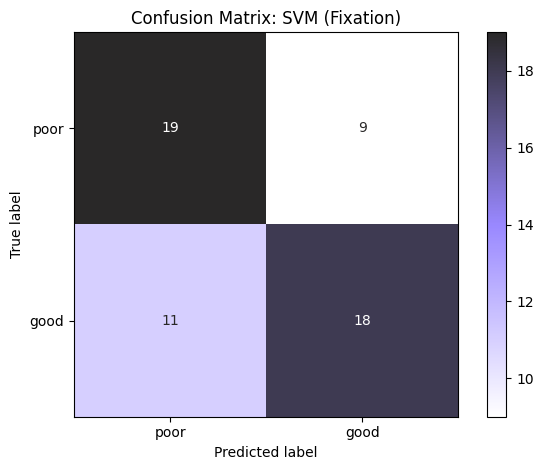

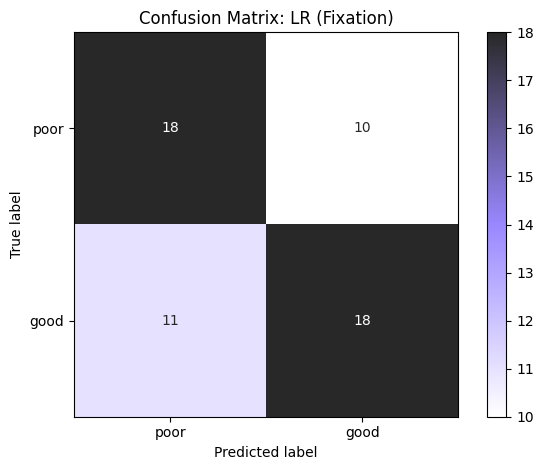

In [8]:
# Plot confusion matrices for significant models
sig = report_df_loo[report_df_loo['Significant']]

for i, row in sig.iterrows():
    model_name = row["Model"]
    feature_name = row["Features"]

    for d in confusion_data_loo:
        if d["Model"] == model_name and d["Features"] == feature_name:
            y_test = d["y_test"]
            y_pred = d["y_pred"]
            break

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1], normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["poor", "good"])
    disp.plot(cmap=cmap_white)
    plt.title(f"Confusion Matrix: {model_name} ({feature_name})")
    plt.tight_layout()
    plt.show()

In [9]:
# Summary
summary_by_feature_set_loo = report_df_loo.groupby("Features")[
    ["Accuracy", "Recall_poor", "Weighted_F1"]
].mean()
summary_by_feature_set_loo = summary_by_feature_set_loo.sort_values(
    by="Accuracy", ascending=False
)
summary_by_feature_set_loo

,Accuracy,Recall_poor,Weighted_F1
Features,,,
Fixation,0.596491,0.625000,0.596164
Spatial,0.548246,0.508929,0.547476
Blinks,0.530702,0.446429,0.524603
Latency,0.521930,0.491071,0.519441
Significant,0.495614,0.366071,0.484015
Most Important,0.482456,0.330357,0.461057
AOI,0.478070,0.330357,0.464373
All,0.464912,0.276786,0.437598
Saccade,0.464912,0.357143,0.455252
